In [26]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


### Functions

### Processing and formatting CV results 

In [27]:
def get_average_and_std_df(results_dict, with_metric_as_index=False):
    losses = results_dict['losses']
    accs = results_dict['accs']
    iso_accs = results_dict['iso_accs']
    sensitivities = results_dict['sensitivities']
    specificities = results_dict['specificities']
    f1_scores = results_dict['F1_scores']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    if with_metric_as_index:
        df_CV.set_index("metric", inplace=True)
    return df_CV


def get_ab_stats_df(results_dict):
    ab_stats_list = results_dict['ab_stats']
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    num_tot = np.array([ab_stats['num_tot'].tolist() for ab_stats in ab_stats_list])
    avg_num = np.mean(num_tot, axis=0).astype(int).tolist()
    std_num = np.std(num_tot, axis=0).tolist()
    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({
        "avg_num": avg_num, "std_num":std_num,
        "S_share_median": s_share_median, "R_share_median": r_share_median,
        "S_share_std":s_share_std, "R_share_std": r_share_std
    })
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        # if np.isnan(arr).any():
        #     print("metric:", metric)
        #     print(arr)
        #     print("avg:", avg)
        #     print("std:", std)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    return df_ab_CV

### TEMPORARY FIX - make sure no GPU tensors are saved in the results
import pickle, io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


### Plotting functions

In [28]:
def plot_metric_by_ab(
    df_CV_ab,
    metric,
    sort_by_desc_metric = True,
    colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red'],
    title = None, 
    figsize = (12, 8), 
    save_path = None
):
    _, ax = plt.subplots(figsize=figsize)
    if sort_by_desc_metric:
        df_CV_ab = df_CV_ab.sort_values(by=(metric+'_avg', 'No PT'), ascending=False)
    df_CV_ab.plot(kind='bar', y=metric+'_avg', yerr=metric+'_std', rot=0, figsize=(13, 8), capsize=2, ecolor='k', color=colors, ax=ax)
    if title:
        if title == 'none':
            pass
        else:
            ax.set_title(title) 
    else:
        ax.set_title(f'{metric} by antibiotic')
    ax.set_xlabel('Antibiotic')
    ax.set_ylabel(metric)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def plot_metric_by_ab_with_distr(
    df_CV_ab,
    metric,
    sort_by_desc_S_share = True,
    show_distr_std = False,
    colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red'],
    title = None, 
    figsize = (12, 8), 
    save_path = None
):
    model_names = df_CV_ab[metric+'_avg'].columns.tolist()
    _, ax = plt.subplots(figsize=(13, 8))
    if sort_by_desc_S_share:
        df_CV_ab = df_CV_ab.sort_values(by='S_share_median', ascending=False)
    ind = np.arange(len(df_CV_ab.index))
    width = 0.15
    for i, model in enumerate(model_names):
        ax.bar(
            ind + (i-1)*width, df_CV_ab[metric+'_avg'][model], width, yerr=df_CV_ab[metric+'_std'][model], 
            label=model, color=colors[i], capsize=2, ecolor='k'
        )
    if show_distr_std:
        ax.bar(ind + 3*width, df_CV_ab['S_share_median'], width, color='darkgreen', label='S share', yerr=df_CV_ab['S_share_std'], capsize=2, ecolor='k')
        ax.bar(ind + 3*width, df_CV_ab['R_share_median'], width, bottom=df_CV_ab['S_share_median'], color='darkred', label='R share', yerr=df_CV_ab['R_share_std'], capsize=2, ecolor='k')
    else:
        ax.bar(ind + 3*width, df_CV_ab['R_share_median'], width, bottom=df_CV_ab['S_share_median'], color='darkred', label='R share')
        ax.bar(ind + 3*width, df_CV_ab['S_share_median'], width, color='darkgreen', label='S share')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(df_CV_ab.index)
    if title:
        if title == 'none':
            pass
        else:
            ax.set_title(title) 
    else:
        ax.set_title(f'{metric} by antibiotic')
    ax.set_xlabel('Antibiotic')
    ax.set_ylabel(metric)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Compare effect of pre-training difficulty and masking method

## PT: Random masking | FT: Random masking

In [29]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [30]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
F1                0.874695  0.875465  0.878521  0.879817  0.009961  0.007237   
Isolate accuracy  0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
Loss              0.149597  0.149192  0.146501  0.148372  0.008172  0.008240   
Sensitivity       0.836947  0.839979  0.840416  0.843100  0.012828  0.011381   
Specificity       0.978131  0.977496  0.979238  0.979059  0.002428  0.002831   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003893  0.003910  
F1                0.008106  0.007803  
Isolate accuracy  0.003893  0.003910  
Loss              0.009087  0.011312  
Sensitivity       0.010033  0.007992  
Specificity       0.002486  0.002961

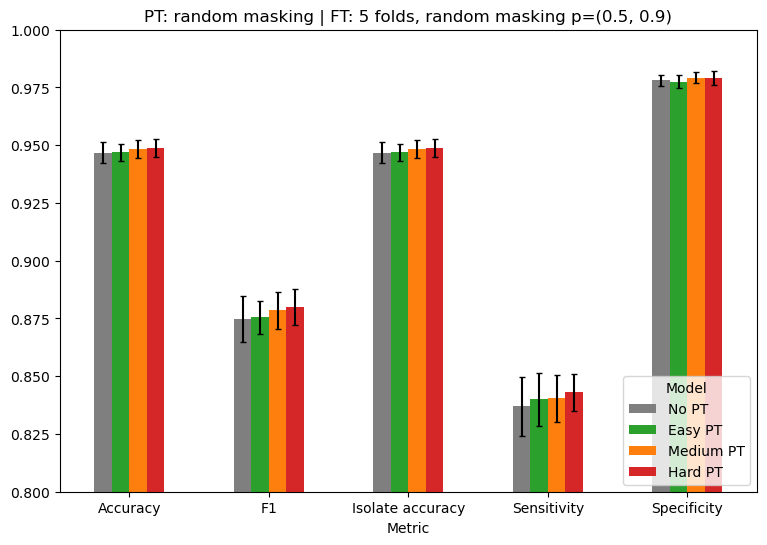

In [31]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, random masking p=(0.5, 0.9)')
plt.show()

### Antibiotic level

In [32]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp
df_CV_ab

avg_num    std_num S_share_median R_share_median S_share_std  \
model                                                                     
antibiotic                                                                
AMP         1365.0   9.002222       0.532943       0.467057    0.007435   
CAZ          763.0   5.635601       0.714472       0.285528    0.007592   
CIP         1392.0   3.600000       0.806196       0.193804    0.003432   
CRO         1300.0  18.271289       0.802870       0.197130    0.008048   
CTX          195.0   5.306600       0.176166       0.823834    0.020343   
FEP          743.0   5.678028       0.819892       0.180108    0.010507   
GEN         1350.0   8.867920       0.873074       0.126926    0.003746   
IPM          650.0   7.761443       0.983025       0.016975    0.003239   
LVX          647.0  19.487432       0.706408       0.293592    0.009065   
MFX           12.0   0.800000       0.333333       0.666667    0.100632   
NAL          750.0  15.370101       0.924603       0.075397    0.006146   
TOB          598.0  12.457929       0.913043       0.086957    0.007915   

           R_share_std accuracy_avg                                ...  \
model                         No PT   Easy PT Medium PT   Hard PT  ...   
antibiotic                                                         ...   
AMP           0.007435     0.890196  0.890790  0.890200  0.891085  ...   
CAZ           0.007592     0.929048  0.926129  0.927454  0.931897  ...   
CIP           0.003432     0.957469  0.958488  0.960782  0.961210  ...   
CRO           0.008048     0.964611  0.964173  0.965384  0.965697  ...   
CTX           0.020343     0.949654  0.947936  0.957950  0.953573  ...   
FEP           0.010507     0.930824  0.931091  0.932203  0.935424  ...   
GEN           0.003746     0.947271  0.945941  0.949486  0.948002  ...   
IPM           0.003239     0.987691  0.989531  0.989231  0.989234  ...   
LVX           0.009065     0.961143  0.961734  0.962329  0.961392  ...   
MFX           0.100632     0.810023  0.840793  0.858974  0.810023  ...   
NAL           0.006146     0.969163  0.969127  0.970451  0.971060  ...   
TOB           0.007915     0.968157  0.972164  0.972519  0.972524  ...   

           precision_std              F1_avg                                \
model          Medium PT   Hard PT     No PT   Easy PT Medium PT   Hard PT   
antibiotic                                                                   
AMP             0.009398  0.014566  0.874755  0.875437  0.874398  0.875606   
CAZ             0.012446  0.003980  0.874644  0.868215  0.868901  0.877865   
CIP             0.008713  0.015885  0.884607  0.889539  0.895163  0.896822   
CRO             0.015544  0.011623  0.905630  0.903967  0.906748  0.907631   
CTX             0.009375  0.011276  0.969796  0.968698  0.974751  0.972021   
FEP             0.041241  0.040035  0.807030  0.809129  0.810536  0.821369   
GEN             0.025789  0.028985  0.772851  0.766297  0.786715  0.778197   
IPM             0.165831  0.081991  0.571707  0.652383  0.628687  0.622062   
LVX             0.013376  0.016034  0.932531  0.934503  0.935134  0.934073   
MFX             0.089883  0.099126  0.839052  0.877148  0.889850  0.839052   
NAL             0.052202  0.073047  0.752318  0.757549  0.758108  0.767031   
TOB             0.019414  0.043410  0.812328  0.836995  0.837983  0.840431   

              F1_std                                
model          No PT   Easy PT Medium PT   Hard PT  
antibiotic                                          
AMP         0.017749  0.017068  0.017739  0.017203  
CAZ         0.023960  0.016729  0.020902  0.011765  
CIP         0.012524  0.009866  0.011285  0.008548  
CRO         0.017020  0.009021  0.012584  0.012907  
CTX         0.006350  0.006830  0.001708  0.007144  
FEP         0.030353  0.026482  0.024496  0.027878  
GEN         0.037402  0.040223  0.025091  0.030707  
IPM         0.084273  0.102445  0.106012  0.083328  
LVX         0.003813

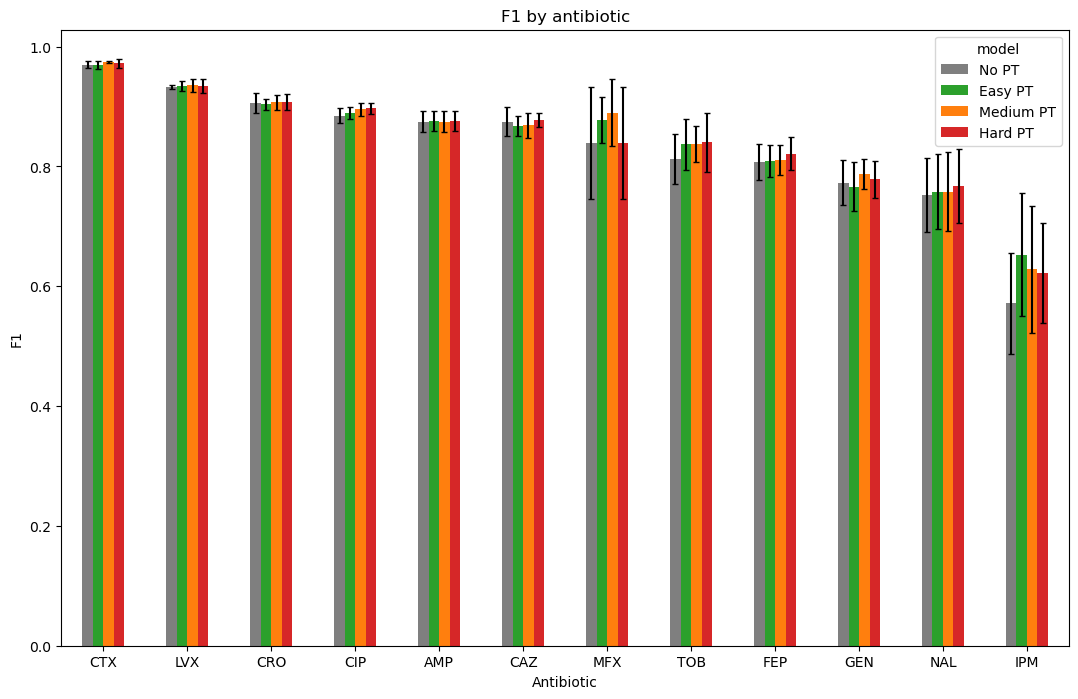

In [33]:
plot_metric_by_ab(df_CV_ab, 'F1')

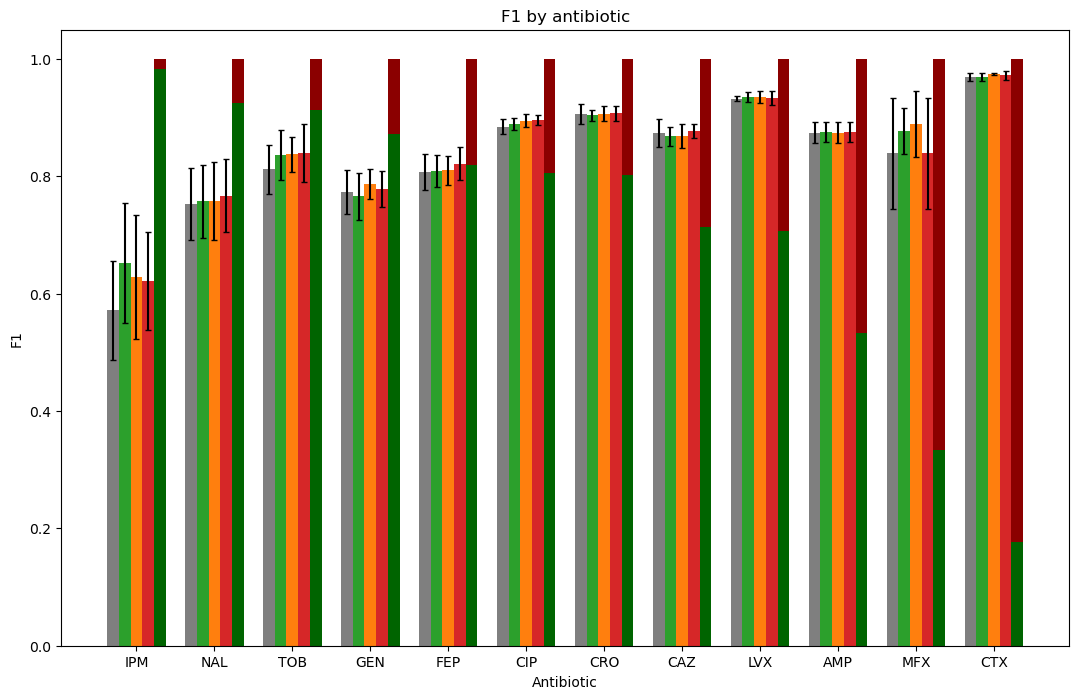

In [34]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## PT: Random masking | FT: Class masking

In [10]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [11]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.947572  0.948383  0.948979  0.949628  0.002161  0.002228   
F1                0.873404  0.874916  0.876475  0.878356  0.004267  0.003956   
Isolate accuracy  0.947572  0.948383  0.948979  0.949628  0.002161  0.002228   
Loss              0.151369  0.148029  0.145753  0.147549  0.008300  0.007169   
Sensitivity       0.836060  0.834348  0.836614  0.840482  0.010292  0.004948   
Specificity       0.978393  0.979842  0.979986  0.979749  0.001231  0.002093   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003364  0.002527  
F1                0.007326  0.004650  
Isolate accuracy  0.003364  0.002527  
Loss              0.009863  0.007940  
Sensitivity       0.007298  0.008009  
Specificity       0.002510  0.001941

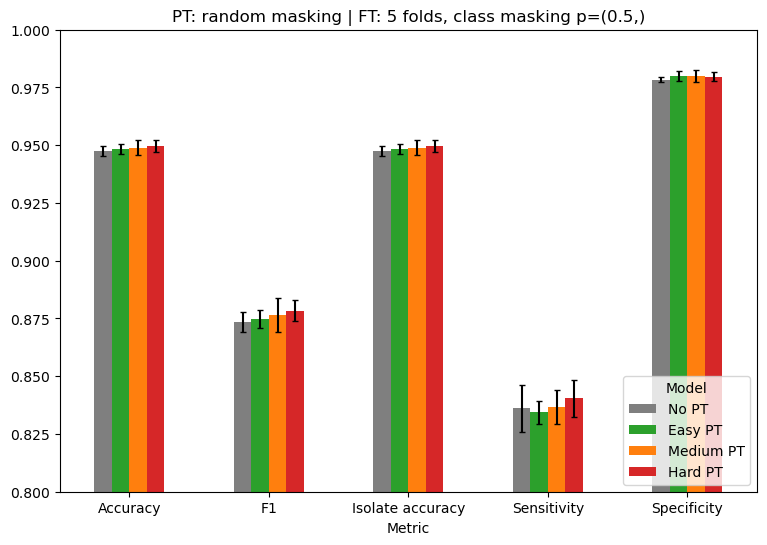

In [12]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, class masking p=(0.5,)')
plt.show()

### Antibiotic level

In [13]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

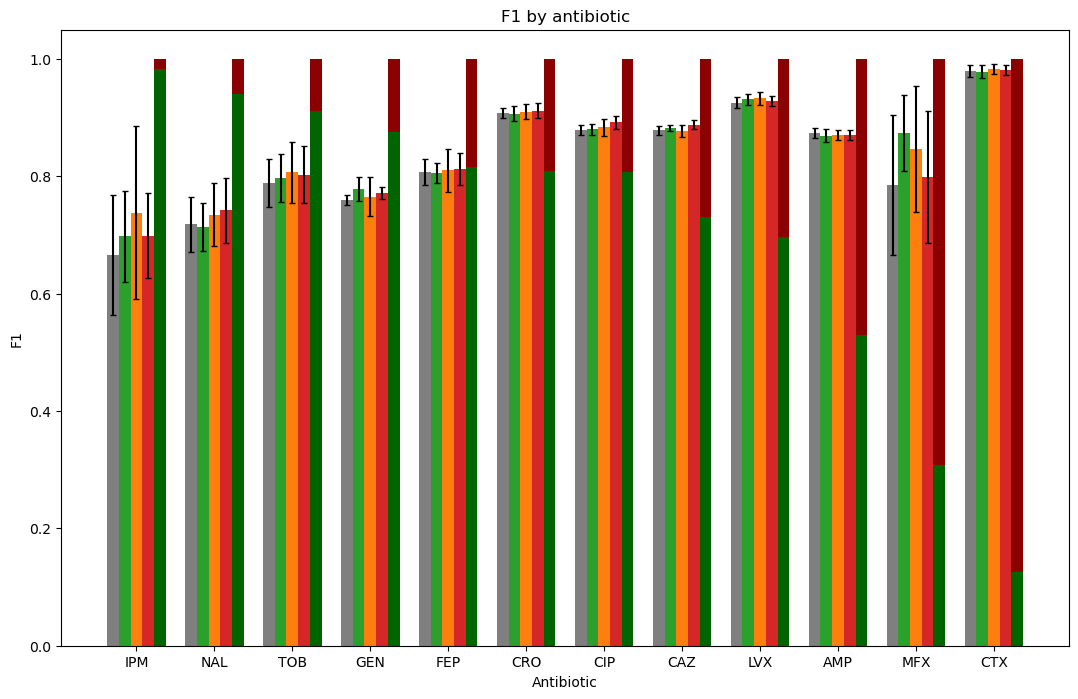

In [14]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## PT: Class masking | FT: Random masking

In [15]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

### Compare metrics

In [16]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
# with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    # results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'))
# model_names = ['No CPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
# colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
model_names = ['No PT', 'Easy CPT', 'Medium CPT']
colors = ['tab:gray', 'tab:green', 'tab:orange']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

In [17]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                            std                     
model                No PT  Easy CPT Medium CPT     No PT  Easy CPT Medium CPT
metric                                                                        
Accuracy          0.946814  0.947611   0.946503  0.004637  0.004291   0.005164
F1                0.874695  0.876991   0.873534  0.009961  0.008907   0.011227
Isolate accuracy  0.946814  0.947611   0.946503  0.004637  0.004291   0.005164
Loss              0.149597  0.148138   0.147769  0.008172  0.009704   0.011967
Sensitivity       0.836947  0.841948   0.832904  0.012828  0.013077   0.014379
Specificity       0.978131  0.977746   0.978890  0.002428  0.003376   0.002658

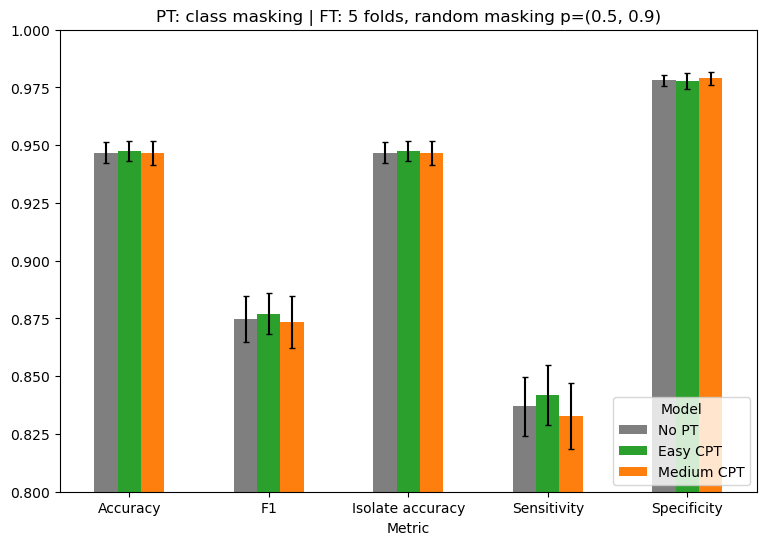

In [18]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, random masking p=(0.5, 0.9)')
plt.show()

### Antibiotic level

In [19]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

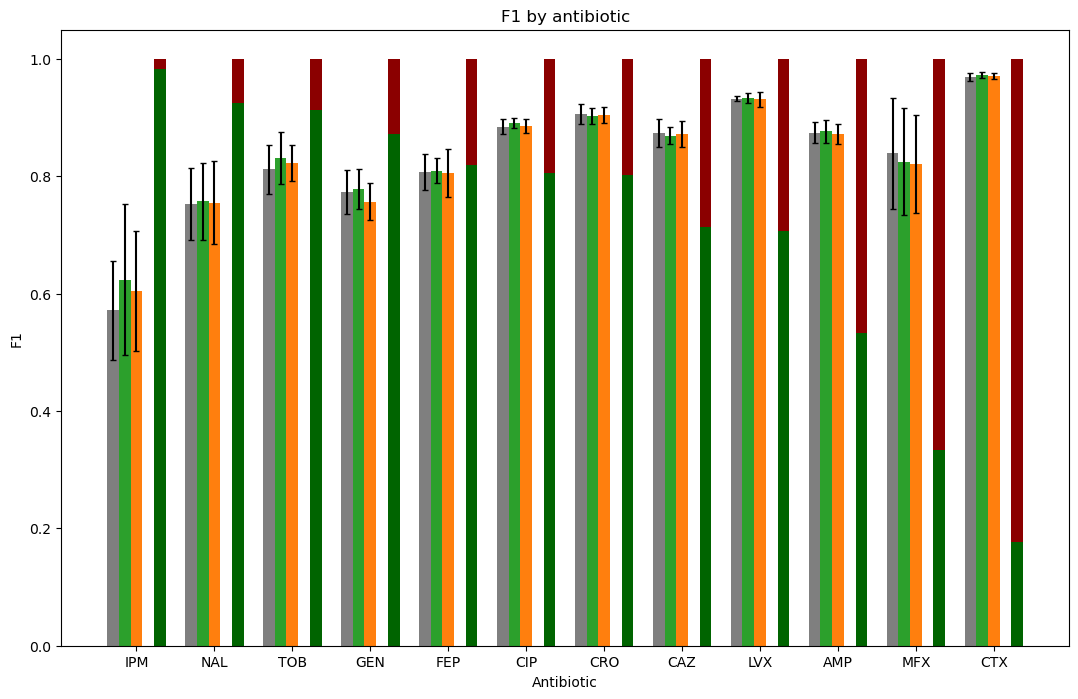

In [20]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## PT: Class masking | FT: Class masking

In [21]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [22]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                      std            \
model                No PT  Easy CPT Medium CPT  Hard CPT     No PT  Easy CPT   
metric                                                                          
Accuracy          0.947572  0.947660   0.948753  0.950298  0.002161  0.002662   
F1                0.873404  0.873679   0.876492  0.879477  0.004267  0.004697   
Isolate accuracy  0.947572  0.947660   0.948753  0.950298  0.002161  0.002662   
Loss              0.151369  0.148669   0.147631  0.146856  0.008300  0.008238   
Sensitivity       0.836060  0.836449   0.840490  0.838171  0.010292  0.009150   
Specificity       0.978393  0.978360   0.978635  0.981268  0.001231  0.003971   

                                       
model            Medium CPT  Hard CPT  
metric                                 
Accuracy           0.002788  0.002883  
F1                 0.005696  0.005968  
Isolate accuracy   0.002788  0.002883  
Loss               0.008179  0.006702  
Sensitivity        0.008301  0.011392  
Specificity        0.001701  0.002151

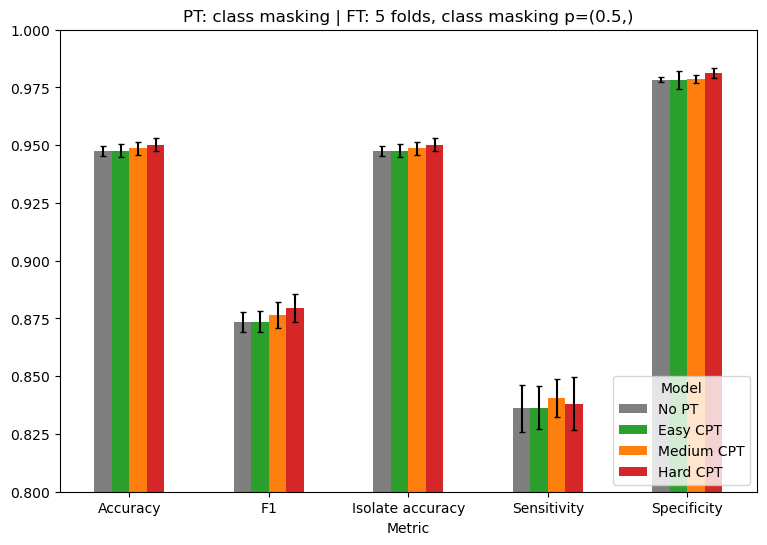

In [23]:
df_CV.drop('Loss').plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model', loc='lower right')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, class masking p=(0.5,)')
plt.show()

### Antibiotic level

In [24]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

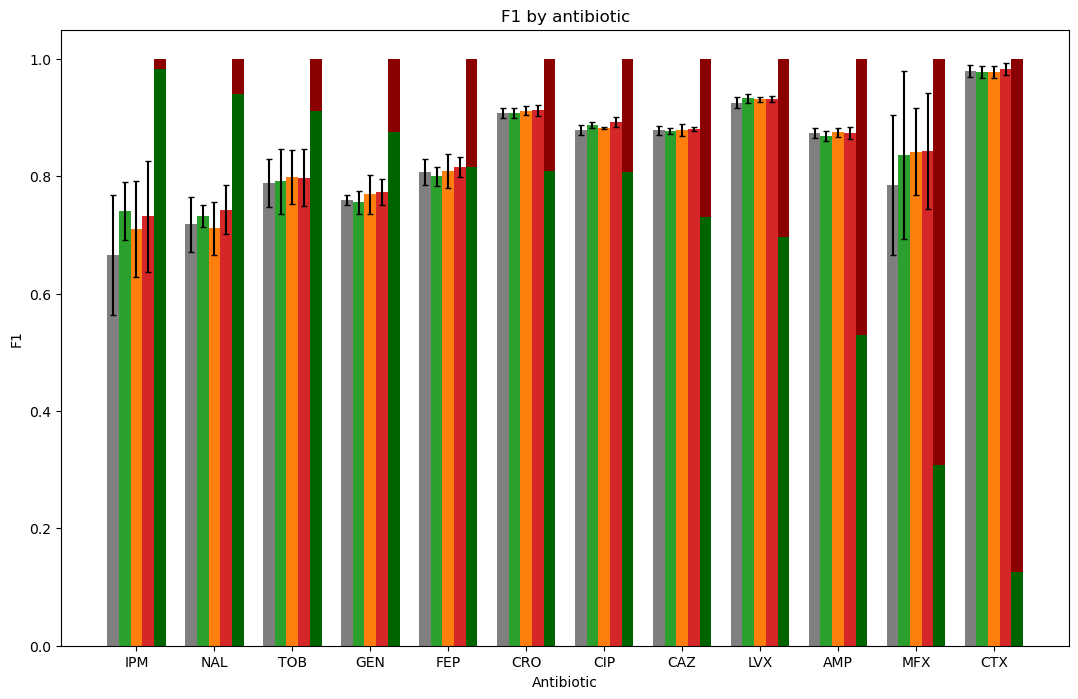

In [25]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## Compare pre-training masking strategies and difficulties

Two alternatives:
1. Compare averages across pre-training difficulties against **no PT**
2. Plot metric values for each pre-training difficulty and method in relation to **no PT**

In [35]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
F1                0.874695  0.875465  0.878521  0.879817  0.009961  0.007237   
Isolate accuracy  0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
Loss              0.149597  0.149192  0.146501  0.148372  0.008172  0.008240   
Sensitivity       0.836947  0.839979  0.840416  0.843100  0.012828  0.011381   
Specificity       0.978131  0.977496  0.979238  0.979059  0.002428  0.002831   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003893  0.003910  
F1                0.008106  0.007803  
Isolate accuracy  0.003893  0.003910  
Loss              0.009087  0.011312  
Sensitivity       0.010033  0.007992  
Specificity       0.002486  0.002961

In [75]:
df_dropped = df_CV.drop(('avg', 'No PT'), axis=1).drop('std', axis=1)
for i in range(df_dropped.shape[0]):
    df_dropped.iloc[i, :] = df_dropped.iloc[i, :] - df_CV.loc[:, ('avg', 'No PT')].values[i]
df_dropped

avg                    
model              Easy PT Medium PT   Hard PT
metric                                        
Accuracy          0.000177  0.001635  0.002086
F1                0.000770  0.003826  0.005122
Isolate accuracy  0.000177  0.001635  0.002086
Loss             -0.000405 -0.003096 -0.001225
Sensitivity       0.003032  0.003469  0.006153
Specificity      -0.000636  0.001107  0.000927

<Axes: xlabel='metric'>

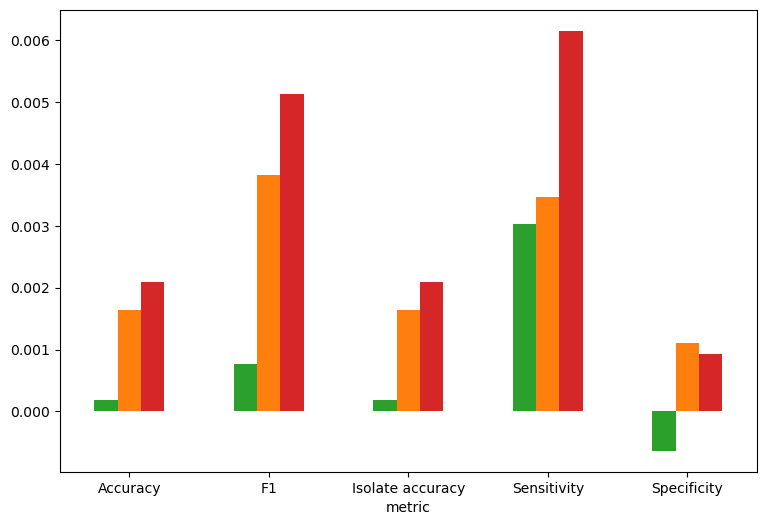

In [79]:
df_dropped.drop('Loss').plot(kind='bar', rot=0, figsize=(9, 6), color=colors[1:], legend=False)